In [1]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import onnxruntime
import os, random
import platform
import time

print("python version:", platform.python_version())
print("torch version:", torch.__version__)
print('ONNX: {}'.format(onnxruntime.get_device()))

python version: 3.7.7
torch version: 1.6.0
ONNX: CPU


In [2]:
# the model (pytorch)
pt_model = models.vgg19(pretrained=True)

for param in pt_model.features.parameters():
    param.requires_grad=False

conv28 = nn.Conv2d(512, 512, 3, 1)
conv30 = nn.Conv2d(512, 512, 3, 1)
conv32 = nn.Conv2d(512, 512, 3, 1)
conv34 = nn.Conv2d(512, 512, 3, 1)

gap = nn.AdaptiveAvgPool2d((1, 1))
first_fc_layer=nn.Linear(512, 1024)
second_fc_layer=nn.Linear(1024, 1024)
last_fc_layer=nn.Linear(1024, 2)
do1=torch.nn.Dropout(p=0, inplace=False)
do2=torch.nn.Dropout(p=0, inplace=False)

pt_model.avgpool = gap
pt_model.classifier[0]=first_fc_layer
pt_model.classifier[3]=second_fc_layer
pt_model.classifier[6]=last_fc_layer
pt_model.classifier[2]=do1
pt_model.classifier[5]=do2

pt_model.features[28]=conv28
pt_model.features[30]=conv30
pt_model.features[32]=conv32
pt_model.features[34]=conv34

pt_model.cpu()

print(pt_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [3]:
# load pytorch model
t0_pt = time.time()
checkpoint = torch.load(r'model/vgg19gap_lowest_val_loss_epoch_5.pth')
pt_model.load_state_dict(checkpoint['state_dict'])
print('PyTorch Model Load Time: {:.2f} seconds'.format(time.time() - t0_pt))
# load onnx model
t0_onnx = time.time()
onnx_model = 'model/vgg19gap_lowest_val_loss_epoch_5.onnx'
onnx_model = onnxruntime.InferenceSession(onnx_model)
print('ONNX Model Load Time: {:.2f} seconds'.format(time.time() - t0_onnx))

PyTorch Model Load Time: 6.88 seconds
ONNX Model Load Time: 1.19 seconds


In [4]:
transform = transforms.Compose([
    transforms.Resize((224 ,224))
    ,transforms.ToTensor()
    ,transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [5]:
def pt_inference(image_path, model):
    model.eval()
    with torch.no_grad():
            # preprocess image
            test_image = Image.open(image_path).convert('RGB')
            test_image = transform(test_image).float()
            test_image = test_image.unsqueeze_(0)
            test_image = test_image.cpu()
            # inference pytorch model
            t0 = time.time()
            test_image = model(test_image)
            t1 = time.time() - t0
            t1 = round(t1, 3)
            test_image = F.softmax(test_image)
    
    Effusion = test_image[0, 0] * 100
    No_Finding = test_image[0, 1] * 100
    true_label = os.path.split(os.path.dirname(image_path))[-1]

    return Effusion, No_Finding, true_label, t1

In [6]:
def onnx_inference(image_path, model):
    # preprocess image
    test_image = Image.open(image_path).convert('RGB')
    test_image = transform(test_image).float()
    test_image = test_image.unsqueeze_(0).numpy()
    # inference onnx model
    test_image = test_image if isinstance(test_image, list) else [test_image]
    test_image = dict([(input.name, test_image[n]) for n, input in enumerate(model.get_inputs())])
    t0 = time.time()
    test_image = model.run(None, test_image)[0]
    t1 = time.time() - t0
    t1 = round(t1, 3)
    test_image = F.softmax(torch.from_numpy(test_image))

    Effusion = test_image[0, 0] * 100
    No_Finding = test_image[0, 1] * 100
    true_label = os.path.split(os.path.dirname(image_path))[-1]

    return Effusion, No_Finding, true_label, t1

True Label : Effusion

PyTorch Pediction :
No Finding - 3.22%
Effusion - 96.78%
Pytorch Model Inference Time (CPU): 0.41 seconds

ONNX Pediction :
No Finding - 3.22%
Effusion - 96.78%
ONNX Model Inference Time (CPU): 0.191 seconds


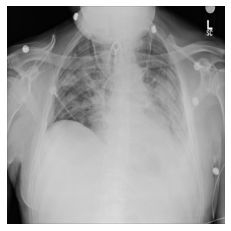

In [8]:
# select random image from directory
No_Finding = random.choice(os.listdir(r"dataset\test_set\No Finding"))
Effusion = random.choice(os.listdir(r"dataset\test_set\Effusion"))
image_path = random.choice([Effusion, No_Finding])

# path of image file
for root, dirs, files in os.walk(r'D:\Data\Documents\Rafi\Python Scripts\Keras_TF_ONNX'):
    for name in files:
        if name == image_path:
            image_path = os.path.abspath(os.path.join(root, name))

# plot predictions
t1 = pt_inference(image_path, pt_model)[3]
t2 = onnx_inference(image_path, onnx_model)[3]

Effusion_PT = round(np.float64(pt_inference(image_path, pt_model)[0].numpy()),2)
No_Finding_PT  = round(np.float64(pt_inference(image_path, pt_model)[1].numpy()),2)

Effusion_ONNX = round(np.float64(onnx_inference(image_path, onnx_model)[0].numpy()),2)
No_Finding_ONNX  = round(np.float64(onnx_inference(image_path, onnx_model)[1].numpy()),2)

true_label = os.path.split(os.path.dirname(image_path))[-1]

plot_image = mpimg.imread(image_path)
plt.imshow(plot_image, cmap="gray")
plt.axis('off')

print('True Label :', true_label)
print('')
print('PyTorch Pediction :')
print('No Finding - ', No_Finding_PT,'%', sep = '')
print('Effusion - ', Effusion_PT,'%', sep = '')
print('Pytorch Model Inference Time (CPU): {} seconds'.format(t1))
print('')
print('ONNX Pediction :')
print('No Finding - ', No_Finding_ONNX,'%', sep = '')
print('Effusion - ', Effusion_ONNX,'%', sep = '')
print('ONNX Model Inference Time (CPU): {} seconds'.format(t2))